# Recommender systems in keras :
In this notebook, we will make a recommender system using Matrix factorization.<br/>
Problem Formulation :<br/>
Given a set of users 'U' and items 'I' and their ratings 'R' by users for items in 'I'. <br/>
Thus, Ratings data D ⊆ U × I × R <br/>
Rating data D are typically represented as a sparse matrix R ∈ R^<sup>|U|×|I|</sup> <br/>
The ratings matrix 'R' thus looks like the following :


![title](image1.png)

The ratings matrix R is usually partially observed:
* No user is able to rate all items
* Most of the items are not rated by all users<br/>
We can estimate the factorization of a matrix from some observations to<br/>
predict its unobserved part as shown below : 
![title](image83.png)

* Each item i ∈ I is associated with a latent feature vector Q<sub>i</sub> ∈ R<sup> K</sup>
* Each user u ∈ U is associated with a latent feature vector P<sub>u</sub> ∈  R<sup> K</sup>
* Each entry in the original matrix can be estimated by : <br/>
<br/>
  \begin{equation*}
  \hat{r}_{u,i} = P_u^T Q_i = \sum_{k=1}^{K} P_{u,k} Q_{i,k}
  \end{equation*}
  
  
* Thus the task is to approximate two matrices P and Q which corresponds to the user and item latent features respectively. How? 
* To approximate we need an objective function which can be the squared loss between the original and predicted ratings.<br/>
  Thus the loss function is : 
 \begin{equation*}
 L  = \sum_{u,i,r_{u,i} ∈ D^{train}}  (r_{u,i} - \hat{r}_{u,i})^2 
  \end{equation*}
  
* Task  : <br/>
 \begin{equation*}
  arg min { L  = \sum_{u,i,r_{u,i} ∈ D^{train}}  (r_{u,i} - \hat{r}_{u,i})^2 }
  \end{equation*}
  
  D<sup>train</sup> = Training data

Once the model is formed in keras, we can use any optimization algorithm <br/>like stochastic gradient descent or adam to backpropagate and update the<br/> values in latent feature matrix P and Q to most closely match the ratings values in R.
<br/>Or in other words, the **mean squared error** between original and predicted ratings is minimum.<br/>


* In this tutorial we will use two methods : 
  * Matrix factorization using keras
  * Neural network approach to learn linear relationships from the latent feature vectors.
<br/>
* We will use **Embeddings layer** in keras to avoid approximating the matrix of size U * I which is generally too sparse. <br/>Detailed explanation on Embeddings and references are included later in this notebook

### Lets start with reading the dataset and preprocessing : 
For now we will consider only the ratings.dat file from movie lens. Later we will add more features of user and items to the latent matrices.

In [1]:
import pandas as pd
from pandas import pivot_table as pivot
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from keras import Sequential

Using Theano backend.


In [2]:
df = pd.read_csv('ratings.csv',error_bad_lines=True)
#shuffle the datasets 
df = df.sample(frac=1,random_state=1)

In [3]:
df.head()

,userId,movieId,rating,timestamp
99778,667,446,4.0,847271818
16170,104,71135,3.5,1446674062
3521,19,1394,5.0,855192061
55070,395,671,5.0,953007109
25477,187,953,3.0,1230361942


* We assign a unique number between (0, #users) to each user and do the same for movies.<br/>


In [4]:
df.userId = df.userId.astype('category').cat.codes.values   #Numpy array of user id's
df.movieId = df.movieId.astype('category').cat.codes.values  #Numpy array for item id's
# df['userId'] = df.user_id
# df['movieId'] = df.item_id
df.head()

,userId,movieId,rating,timestamp
99778,666,395,4.0,847271818
16170,103,7295,3.5,1446674062
3521,18,1132,5.0,855192061
55070,394,575,5.0,953007109
25477,186,773,3.0,1230361942


In [5]:
table = pivot(df,values= 'rating',index = 'userId',columns='movieId')
table

movieId,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* In the above cell we can see the rating matrix D of size 671 users × 9066 movies. But as we will use Embeddings for this task we do not need to decompose the matrix of this big size.

* Dividing the dataframe into train and test: 


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [7]:
train.head()
# test

,userId,movieId,rating,timestamp
86585,579,498,3.5,1167159391
98434,658,197,3.0,835642424
13756,87,7030,4.5,1239775107
73008,508,3229,3.0,1037842687
7733,47,7379,3.0,1414562131


# 1. Matrix factorization using keras : 

In [8]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

num_users = len(df.userId.unique())
num_movies = len(df.movieId.unique())
n_latent_factors = 3      #Hyperparameter
print("Number of movies are:",num_movies)
print("Number of users are:",num_users)

Number of movies are: 9066
Number of users are: 671


* Before we start to form a keras model for matrix factorization lets dive into the concept of using low dimensional **embedding** instead of the ratings matrix R. 
* **Why to use embeddings ? **
  * One-hot encoded vectors are high-dimensional and sparse. Lets take the example of movie lens dataset. We have around 700 users and 9000 items. Thus, when using one hot encoding or pivot matrix as shown above, we have a matrix of size ~700   * 9000.This means that, when using pivot, each user item pair will be represented by a vector containing 9000 integers. And suppose the user has rated only one 10 items, then 8990 of these integers are zeros. In a big dataset this approach is not computationally efficient.
  * The vectors of each embedding get updated while training the neural network. This allows us to visualize relationships between users and items, but also between everything that can be turned into a vector through an embedding layer. Thus we can generate embeddings for indexes of users' or items' features such as occupation, age, genre etc. even after including more features the vector will still be low-dimensional.
  
What exactly is the input and output of the embedding layer?  To understand this lets use the embedding layer for this dataset.

In [12]:
"Creating a sample sequential model"
model = Sequential()

"Embedding layer > input_dim = dimension of input vector "
"                  output_dim = Number of latent features "
model.add(keras.layers.Embedding(input_dim=num_movies+1,output_dim=n_latent_factors , input_length=1))
"the model will take as input an integer matrix of size (batch, input_length)."
" We input the item_id in the range 1 - 9066 of shape [1] and get output of shape [1 * n_latent_factors]"
input_array =df.item_id

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)


In [13]:
print("shape of input to the embedding layer", df.item_id.shape)
print("shape of output to the embedding layer",output_array.shape)

shape of input to the embedding layer (100004,)
shape of output to the embedding layer (100004, 1, 3)


In [14]:
output_array_reshaped=output_array.reshape((100004,3))
df_movies_with_latent_factors = pd.DataFrame(output_array_reshaped,index=df.item_id,columns=['LF1','LF2','LF3'])

In [15]:
df_movies_with_latent_factors.head()

,LF1,LF2,LF3
395,-0.038270,-0.045317,-0.008740
7295,-0.006597,0.045694,-0.041967
1132,-0.042058,0.038397,-0.049588
575,-0.032411,0.028631,0.031273
773,-0.045801,0.011517,0.024187


In [16]:
df_movies_with_latent_factors.to_csv('moviesEmbeddings.csv')

* Thus the embedding layer has converted each item index to a random number vector of the given output shape(latent features).
<br/>

* Doing the same for users indexes we will have similar matrix. 
* These embedding matrices correspond to the matrix P and Q discussed above.
* Thus next steps to be done are : 
    * Dot product of P and Q to predict ratings of all users for all items
    * Optimizing over the loss between predicted and actual ratings and update P and Q values to get more closer to actual ratings.
    * Stop training when loss is less and then use P and Q matrices to predict rating R for any user U to item I using:
  \begin{equation*}
  \hat{r}_{u,i} = P_u^T Q_i = \sum_{k=1}^{K} P_{u,k} Q_{i,k}
  \end{equation*}
  
  Where : K = number of Latent features


To read more about embedding layers, here is a blogpost for reference : https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12

## Now lets begin the keras model for matrix factorization : 

In [17]:
df.head()

,userId,movieId,rating,timestamp
99778,666,395,4.0,847271818
16170,103,7295,3.5,1446674062
3521,18,1132,5.0,855192061
55070,394,575,5.0,953007109
25477,186,773,3.0,1230361942


In [18]:
from keras.constraints import non_neg

"Latent feature vector for movies"
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(num_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

"Latent feature vector for users"
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(num_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

"Merge the user and movie latent vectors using dot product"
prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')

"Build model and compile"
model_vanilla_MF = keras.Model([user_input, movie_input], prod)

"Using Adam optimizer to backpropagate"
model_vanilla_MF.compile('adam', 'mean_squared_error')

### Visualization of model :

In [19]:
model_vanilla_MF.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         27201       Item[0][0]                       
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         2016        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

* The model takes two inputs  : <br/> 1. Item input (Q) which is the movie latent feature <br/> 2. User input (P) for users latent features <br/>
* Then the movie and user embeddings are created. 
* The embeddings are then flattened and merged using **dot** product.
* Then we will have the predicted rating matrix *R* 
* Error is then calcuated, which is this case is "mean squared error"
* Backpropagate and update P and Q using ADAM to minimize this error. Once the error is low we can say the predicted ratings are close to the actual ratings. 
* ** Now lets begin training the model**

In [20]:
" Lets see the values we will use to input" 
train.head()

,userId,movieId,rating,timestamp
77482,535,393,1.0,829471720
94404,623,4670,0.5,1262200449
76847,531,4098,2.5,1076971785
20490,136,1575,4.0,946411720
15177,98,1263,1.0,938586764


In [115]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)
history = model_vanilla_MF.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=2,validation_split=0.1,
                               callbacks=[tensorboard])


Train on 72002 samples, validate on 8001 samples
Epoch 1/50
 - 4s - loss: 0.6040 - val_loss: 1.2527
Epoch 2/50
 - 3s - loss: 0.6010 - val_loss: 1.2570
Epoch 3/50
 - 3s - loss: 0.5978 - val_loss: 1.2613
Epoch 4/50
 - 4s - loss: 0.5949 - val_loss: 1.2653
Epoch 5/50
 - 3s - loss: 0.5922 - val_loss: 1.2672
Epoch 6/50
 - 3s - loss: 0.5895 - val_loss: 1.2715
Epoch 7/50
 - 3s - loss: 0.5870 - val_loss: 1.2741
Epoch 8/50
 - 3s - loss: 0.5853 - val_loss: 1.2749
Epoch 9/50
 - 3s - loss: 0.5828 - val_loss: 1.2800
Epoch 10/50
 - 3s - loss: 0.5806 - val_loss: 1.2816
Epoch 11/50
 - 4s - loss: 0.5785 - val_loss: 1.2865
Epoch 12/50
 - 3s - loss: 0.5764 - val_loss: 1.2874
Epoch 13/50
 - 3s - loss: 0.5742 - val_loss: 1.2888
Epoch 14/50
 - 3s - loss: 0.5726 - val_loss: 1.2903
Epoch 15/50
 - 4s - loss: 0.5710 - val_loss: 1.2936
Epoch 16/50
 - 4s - loss: 0.5692 - val_loss: 1.2947
Epoch 17/50
 - 4s - loss: 0.5674 - val_loss: 1.2980
Epoch 18/50
 - 4s - loss: 0.5660 - val_loss: 1.3011
Epoch 19/50
 - 3s - loss

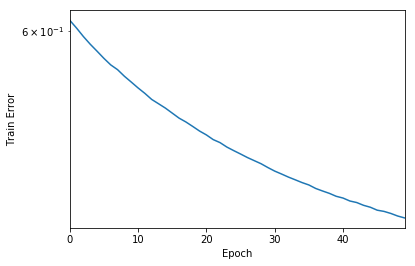

In [116]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
# history.history['loss']

In [117]:
# x_test = np.stack((test.userId,test.movieId),axis = 1)
# print(x_test)

y_hat = np.round(model_vanilla_MF.predict([test.userId, test.movieId]),decimals=0)

y_true = test.rating
y_true = np.array(test.rating)


In [118]:

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.81823408829558519

In [119]:
test.head()
test['perdicted ratings']=y_hat

In [120]:
print("predicted ratings: ")
test.head()


predicted ratings: 


,userId,movieId,rating,timestamp,perdicted ratings
55624,401,5478,3.0,1443394485,3.0
97830,653,2531,5.0,1145390304,5.0
57207,411,3226,2.0,993086634,3.0
9041,57,2019,2.0,961127761,2.0
30882,219,870,4.0,970507667,4.0


Thus, we did matrix factorization using keras to approximate the ratings matrix. <br/>
Next, let's build a neural network model to implement recommender system.

## Recommender systems :  Neural networks

In [15]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(num_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(num_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [17]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         72536       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3360        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [18]:

training = model.fit(x=[train.userId, train.movieId], y=train.rating, epochs=250,verbose=2)


Epoch 1/250
 - 7s - loss: 0.7599
Epoch 2/250
 - 10s - loss: 0.6950
Epoch 3/250
 - 11s - loss: 0.6736
Epoch 4/250
 - 13s - loss: 0.6643
Epoch 5/250
 - 11s - loss: 0.6553
Epoch 6/250
 - 11s - loss: 0.6478
Epoch 7/250
 - 12s - loss: 0.6437
Epoch 8/250
 - 11s - loss: 0.6402
Epoch 9/250
 - 11s - loss: 0.6358
Epoch 10/250
 - 12s - loss: 0.6320
Epoch 11/250
 - 13s - loss: 0.6289
Epoch 12/250
 - 11s - loss: 0.6255
Epoch 13/250
 - 11s - loss: 0.6238
Epoch 14/250
 - 11s - loss: 0.6208
Epoch 15/250
 - 11s - loss: 0.6199
Epoch 16/250
 - 11s - loss: 0.6183
Epoch 17/250
 - 11s - loss: 0.6152
Epoch 18/250
 - 11s - loss: 0.6144
Epoch 19/250
 - 11s - loss: 0.6135
Epoch 20/250
 - 11s - loss: 0.6131
Epoch 21/250
 - 15s - loss: 0.6105
Epoch 22/250
 - 14s - loss: 0.6087
Epoch 23/250
 - 12s - loss: 0.6101
Epoch 24/250
 - 11s - loss: 0.6082
Epoch 25/250
 - 11s - loss: 0.6076
Epoch 26/250
 - 12s - loss: 0.6066
Epoch 27/250
 - 12s - loss: 0.6066
Epoch 28/250
 - 13s - loss: 0.6046
Epoch 29/250
 - 11s - loss: 0.

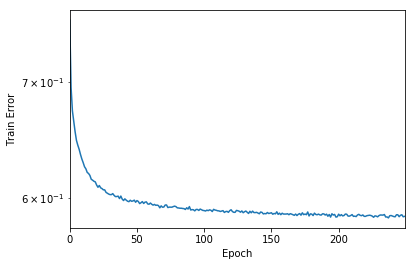

In [19]:
pd.Series(training.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [20]:

y_hat = np.round(model.predict([test.userId, test.movieId]),decimals=0)

y_true = test.rating
y_true = np.array(test.rating)

In [21]:

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.66931653417329129

## Now we will include the "extra" factors of users and movies into the input : 
To do so, we can learn *embeddings* for the extra factors we wish to include. <br/> The vector embeddings of the extra factors can be then be simply stacked with the user ID or movie ID vectors.<br/> Another way of doing it is to include another input layer dedicated to extra factors. Lets include an extra input layer for the extra factors and build the neural network. To compare the performance we will keep the parameters of the previous neural network unchanged.

In [9]:
movies = pd.read_csv('movies.csv',sep=',')
movies['genre'] = movies.genres.str.split('|')

In [37]:
movies.head()

,movieId,title,genres,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [81]:
movies.movieId = movies.movieId.astype('category').cat.codes.values #Numpy array for item id's
movies.genres = movies.genres.astype('category').cat.codes.values
movies.movieId.unique()
movies.head()
df_genre = pd.DataFrame([movies.movieId,movies.genres])
movies.head()
df_genre.head()

,0,1,2,3,4,5,6,7,8,9,...,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124
movieId,0,1,2,3,4,5,6,7,8,9,...,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124
genres,328,393,686,645,595,241,686,376,1,123,...,803,110,761,761,892,454,105,748,595,748


In [71]:
df_sorted_movieId=df.sort_values('movieId')
df_sorted_movieId.head()
# df.head()

,userId,movieId,rating,timestamp
70088,483,0,3.0,851345204
89327,595,0,3.5,1145034973
76593,529,0,5.0,879014231
59530,430,0,4.5,1165547529
63772,458,0,5.0,859210690


In [74]:
df_sorted_movieId.merge(df_genre,how='inner')

MergeError: No common columns to perform merge on

In [59]:
num_movie_genre=len(movies.genres.unique())
movies.dtypes

movieId     int16
title      object
genres      int16
genre      object
dtype: object

In [60]:
"Creating a sample sequential model"
model = Sequential()

"Embedding layer > input_dim = dimension of input vector "
"                  output_dim = Number of latent features "
model.add(keras.layers.Embedding(input_dim=num_movie_genre+1,output_dim=5 , input_length= 1))
"the model will take as input an integer matrix of size (batch, input_length)."
" We input the item_id in the range 1 - 9066 of shape [1] and get output of shape [1 * n_latent_factors]"
input_array =movies.genres

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

In [65]:
output_array

array([[[ 0.02087205,  0.0175561 , -0.03101997,  0.02893331, -0.02056722]],

       [[-0.01480265, -0.00799886, -0.01628273, -0.01967268, -0.04088835]],

       [[ 0.02612372,  0.01650136, -0.01789467,  0.04688015, -0.03115863]],

       ..., 
       [[-0.00062101, -0.0447359 ,  0.00849695,  0.0392585 ,  0.04257723]],

       [[ 0.02054017, -0.01327827, -0.00536516, -0.03820894,  0.04680843]],

       [[-0.00062101, -0.0447359 ,  0.00849695,  0.0392585 ,  0.04257723]]], dtype=float32)